In [46]:
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import cv2 as cv
import torch

import sys
import yaml
from pathlib import Path

sys.path.append("../")
sys.path.append("../../modules/yolov5/")
from reef.yolo.data.dataset import LoadImagesAndLabels
from reef.yolo.lightning import YOLOModel
from reef.plot import plot_pil
from utils.autoanchor import check_anchors

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SLICE_HEIGHT = 360
SLICE_WIDTH = 640
IMG_SIZE = 640
STRIDE = 32
RANDOM_STATE = 42
OVERLAP_THRESHOLD = 0.25

dataset_params = {
    'slice_height': SLICE_HEIGHT,
    'slice_width': SLICE_WIDTH,
    'overlap_threshold': OVERLAP_THRESHOLD
}

In [120]:
split_path = Path("../../data/splits/s50/")

with open(split_path / "data.yaml") as f:
    data = yaml.safe_load(f)
    
with open("../reef/yolo/hyp.yaml") as f:
    hyp = yaml.safe_load(f)
    
data

{'names': ['starfish'],
 'nc': 1,
 'train': '/home/isabella/code/competitions/great_barrier_reef/data/splits/s50/train.txt',
 'val': '/home/isabella/code/competitions/great_barrier_reef/data/splits/s50/valid.txt'}

In [121]:
dataset = LoadImagesAndLabels(
    path=data['train'], 
    slice_height=SLICE_HEIGHT,
    slice_width=SLICE_WIDTH,
    overlap_threshold=0.75,
    img_size=640,
    augment=True,
    stride=STRIDE,
    random_state=42,
    hyp=hyp,
    prefix="train: "
)

In [122]:
def plot_sample(idx):
    image, labels, path, box = dataset[idx]
    print(image.shape)
    return plot_pil(image, labels.numpy()[:, 2:])
    
    
def plot_original(idx):
    path = dataset.img_paths[idx]
    orig_labels = np.array(dataset.labels[idx])[:, 1:]
    
    orig_image = torch.tensor(np.ascontiguousarray(cv.imread(path).transpose((2, 0, 1))[::-1]))

    return plot_pil(orig_image, orig_labels)

train:  (360, 640, 3) [504, 130, 1144, 490]
torch.Size([3, 384, 640])
[        535          95          50          32]


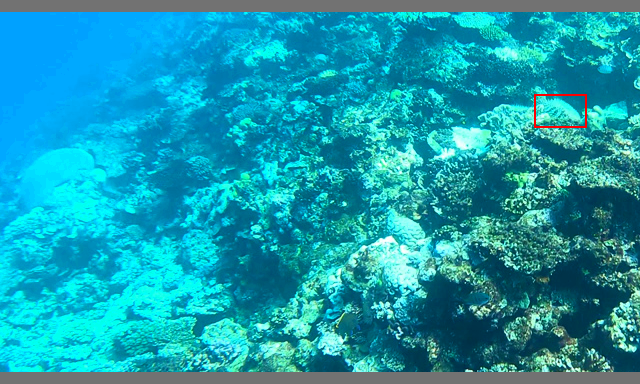

In [143]:
plot_sample(0)

[        559         213          50          32]


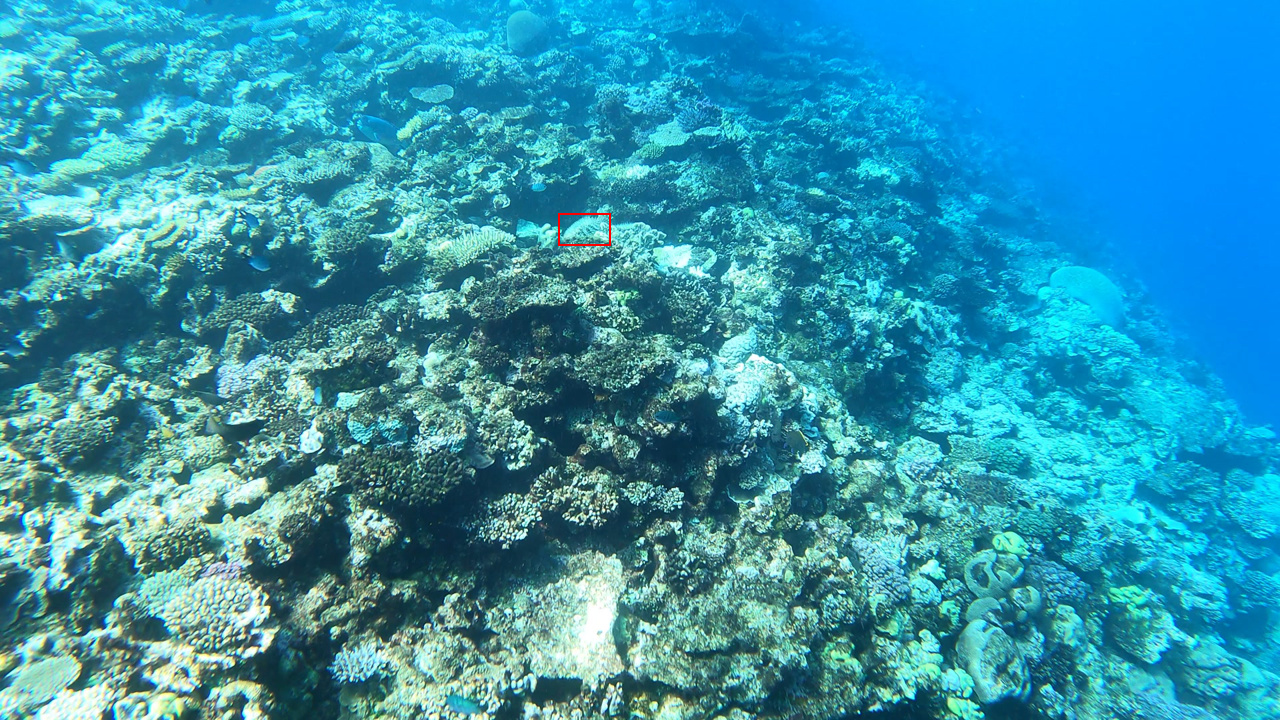

In [65]:
plot_original(0)

In [5]:
from reef.yolo.callbacks import AverageEpochMetricsCallback, ProgressCallback

average_epoch_metrics_callback = AverageEpochMetricsCallback()
progress_callback = ProgressCallback()

module.setup("validate")

trainer = pl.Trainer(
    max_epochs=50,
    max_time={"hours": 12},
    check_val_every_n_epoch=1,
    num_processes=2,
    accumulate_grad_batches=module.accumulate,
    callbacks=[
        progress_callback,
        average_epoch_metrics_callback,
    ],
)
trainer.fit(module)

Both every_n_train_steps and every_n_epochs are not set. Setting every_n_epochs=1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Stage: TrainerFn.FITTING


initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
Added key: store_based_barrier_key:1 to store for rank: 1
Added key: store_based_barrier_key:1 to store for rank: 0
Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------


  | Name  | Type  | Params
--------------------------------
0 | model | Model | 7.0 M 
--------------------------------
6.5 M     Trainable params
526 K     Non-trainable params
7.0 M     Total params
28.089    Total estimated model params size (MB)
/home/isabella/code/competitions/great_barrier_reef/env/lib/p

Epoch 0:   0%|          | 0/298 [00:00<?, ?it/s]                      

/home/isabella/code/competitions/great_barrier_reef/env/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/home/isabella/code/competitions/great_barrier_reef/env/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:87: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  "num_workers>0, persistent_workers=False, and strategy=ddp_spawn"


Epoch 0:   1%|          | 3/298 [00:18<31:03,  6.32s/it, loss=0.407, v_num=1, labels=0]  

[W reducer.cpp:1303] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1303] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Epoch 0:  80%|███████▉  | 238/298 [09:34<02:24,  2.41s/it, loss=0.306, v_num=1, labels=4]
Validating: 0it [00:00, ?it/s]
Epoch 1:   0%|          | 0/298 [00:00<?, ?it/s, loss=0.306, v_num=1]          

/home/isabella/code/competitions/great_barrier_reef/env/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Epoch 1:  80%|███████▉  | 238/298 [09:17<02:20,  2.34s/it, loss=0.237, v_num=1, labels=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 298/298 [10:32<00:00,  2.12s/it, loss=0.237, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=0-step=59.ckpt


Epoch 2:  80%|███████▉  | 238/298 [09:19<02:20,  2.35s/it, loss=0.294, v_num=1, labels=3]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 298/298 [10:33<00:00,  2.13s/it, loss=0.294, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=1-step=119.ckpt


Epoch 3:  80%|███████▉  | 238/298 [09:16<02:20,  2.34s/it, loss=0.325, v_num=1, labels=4]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 298/298 [10:31<00:00,  2.12s/it, loss=0.325, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=2-step=179.ckpt


Epoch 4:  80%|███████▉  | 238/298 [09:19<02:21,  2.35s/it, loss=0.233, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 298/298 [10:33<00:00,  2.13s/it, loss=0.233, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=3-step=239.ckpt


Epoch 5:  80%|███████▉  | 238/298 [09:18<02:20,  2.35s/it, loss=0.297, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 298/298 [10:35<00:00,  2.13s/it, loss=0.297, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=4-step=299.ckpt


Epoch 6:  80%|███████▉  | 238/298 [09:18<02:20,  2.35s/it, loss=0.275, v_num=1, labels=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 298/298 [10:32<00:00,  2.12s/it, loss=0.275, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=5-step=359.ckpt


Epoch 7:  80%|███████▉  | 238/298 [09:13<02:19,  2.32s/it, loss=0.294, v_num=1, labels=2]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 298/298 [10:27<00:00,  2.11s/it, loss=0.294, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=6-step=419.ckpt


Epoch 8:  80%|███████▉  | 238/298 [09:14<02:19,  2.33s/it, loss=0.323, v_num=1, labels=2]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 298/298 [10:27<00:00,  2.11s/it, loss=0.323, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=7-step=479.ckpt


Epoch 9:  80%|███████▉  | 238/298 [09:15<02:19,  2.33s/it, loss=0.259, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 298/298 [10:29<00:00,  2.11s/it, loss=0.259, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=8-step=539.ckpt


Epoch 10:  80%|███████▉  | 238/298 [09:14<02:19,  2.33s/it, loss=0.278, v_num=1, labels=4]
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 298/298 [10:29<00:00,  2.11s/it, loss=0.278, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=9-step=599.ckpt


Epoch 11:  80%|███████▉  | 238/298 [09:15<02:20,  2.33s/it, loss=0.318, v_num=1, labels=2]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████| 298/298 [10:29<00:00,  2.11s/it, loss=0.318, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=10-step=659.ckpt


Epoch 12:  80%|███████▉  | 238/298 [09:26<02:22,  2.38s/it, loss=0.293, v_num=1, labels=0]
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████| 298/298 [10:41<00:00,  2.15s/it, loss=0.293, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=11-step=719.ckpt


Epoch 13:  80%|███████▉  | 238/298 [09:13<02:19,  2.33s/it, loss=0.337, v_num=1, labels=3]
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████| 298/298 [10:27<00:00,  2.11s/it, loss=0.337, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=12-step=779.ckpt


Epoch 14:  80%|███████▉  | 238/298 [09:14<02:19,  2.33s/it, loss=0.33, v_num=1, labels=2] 
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████| 298/298 [10:29<00:00,  2.11s/it, loss=0.33, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=13-step=839.ckpt


Epoch 15:  80%|███████▉  | 238/298 [09:13<02:19,  2.33s/it, loss=0.278, v_num=1, labels=2] 
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|██████████| 298/298 [10:27<00:00,  2.11s/it, loss=0.278, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=14-step=899.ckpt


Epoch 16:  80%|███████▉  | 238/298 [09:16<02:20,  2.34s/it, loss=0.316, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 16: 100%|██████████| 298/298 [10:31<00:00,  2.12s/it, loss=0.316, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=15-step=959.ckpt


Epoch 17:  80%|███████▉  | 238/298 [09:16<02:20,  2.34s/it, loss=0.271, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 17: 100%|██████████| 298/298 [10:32<00:00,  2.12s/it, loss=0.271, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=16-step=1019.ckpt


Epoch 18:  80%|███████▉  | 238/298 [09:16<02:20,  2.34s/it, loss=0.292, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 18: 100%|██████████| 298/298 [10:31<00:00,  2.12s/it, loss=0.292, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=17-step=1079.ckpt


Epoch 19:  80%|███████▉  | 238/298 [09:11<02:19,  2.32s/it, loss=0.344, v_num=1, labels=2]
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 298/298 [10:25<00:00,  2.10s/it, loss=0.344, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=18-step=1139.ckpt


Epoch 20:  80%|███████▉  | 238/298 [09:12<02:19,  2.32s/it, loss=0.35, v_num=1, labels=4] 
Validating: 0it [00:00, ?it/s]
Epoch 20: 100%|██████████| 298/298 [10:25<00:00,  2.10s/it, loss=0.35, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=19-step=1199.ckpt


Epoch 21:  80%|███████▉  | 238/298 [09:12<02:19,  2.32s/it, loss=0.331, v_num=1, labels=2]
Validating: 0it [00:00, ?it/s]
Epoch 21: 100%|██████████| 298/298 [10:26<00:00,  2.10s/it, loss=0.331, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=20-step=1259.ckpt


Epoch 22:  80%|███████▉  | 238/298 [09:11<02:19,  2.32s/it, loss=0.316, v_num=1, labels=2]
Validating: 0it [00:00, ?it/s]
Epoch 22: 100%|██████████| 298/298 [10:25<00:00,  2.10s/it, loss=0.316, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=21-step=1319.ckpt


Epoch 23:  80%|███████▉  | 238/298 [09:14<02:19,  2.33s/it, loss=0.294, v_num=1, labels=5]
Validating: 0it [00:00, ?it/s]
Epoch 23: 100%|██████████| 298/298 [10:29<00:00,  2.11s/it, loss=0.294, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=22-step=1379.ckpt


Epoch 24:  80%|███████▉  | 238/298 [09:17<02:20,  2.34s/it, loss=0.322, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|██████████| 298/298 [10:32<00:00,  2.12s/it, loss=0.322, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=23-step=1439.ckpt


Epoch 25:  80%|███████▉  | 238/298 [09:15<02:20,  2.33s/it, loss=0.277, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|██████████| 298/298 [10:30<00:00,  2.12s/it, loss=0.277, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=24-step=1499.ckpt


Epoch 26:  80%|███████▉  | 238/298 [09:18<02:20,  2.35s/it, loss=0.318, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|██████████| 298/298 [10:33<00:00,  2.13s/it, loss=0.318, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=25-step=1559.ckpt


Epoch 27:  80%|███████▉  | 238/298 [09:16<02:20,  2.34s/it, loss=0.272, v_num=1, labels=3]
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|██████████| 298/298 [10:30<00:00,  2.12s/it, loss=0.272, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=26-step=1619.ckpt


Epoch 28:  80%|███████▉  | 238/298 [09:14<02:19,  2.33s/it, loss=0.237, v_num=1, labels=0] 
Validating: 0it [00:00, ?it/s]
Epoch 28: 100%|██████████| 298/298 [10:28<00:00,  2.11s/it, loss=0.237, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=27-step=1679.ckpt


Epoch 29:  80%|███████▉  | 238/298 [09:14<02:19,  2.33s/it, loss=0.316, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 298/298 [10:28<00:00,  2.11s/it, loss=0.316, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=28-step=1739.ckpt


Epoch 30:  80%|███████▉  | 238/298 [09:14<02:19,  2.33s/it, loss=0.246, v_num=1, labels=0]
Validating: 0it [00:00, ?it/s]
Epoch 30: 100%|██████████| 298/298 [10:29<00:00,  2.11s/it, loss=0.246, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=29-step=1799.ckpt


Epoch 31:  80%|███████▉  | 238/298 [09:16<02:20,  2.34s/it, loss=0.267, v_num=1, labels=0] 
Validating: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████| 298/298 [10:31<00:00,  2.12s/it, loss=0.267, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=30-step=1859.ckpt


Epoch 32:  80%|███████▉  | 238/298 [09:19<02:20,  2.35s/it, loss=0.288, v_num=1, labels=3]
Validating: 0it [00:00, ?it/s]
Epoch 32: 100%|██████████| 298/298 [10:34<00:00,  2.13s/it, loss=0.288, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=31-step=1919.ckpt


Epoch 33:  80%|███████▉  | 238/298 [09:16<02:20,  2.34s/it, loss=0.324, v_num=1, labels=4]
Validating: 0it [00:00, ?it/s]
Epoch 33: 100%|██████████| 298/298 [10:31<00:00,  2.12s/it, loss=0.324, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=32-step=1979.ckpt


Epoch 34:  80%|███████▉  | 238/298 [09:18<02:20,  2.35s/it, loss=0.273, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 34: 100%|██████████| 298/298 [10:33<00:00,  2.12s/it, loss=0.273, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=33-step=2039.ckpt


Epoch 35:  80%|███████▉  | 238/298 [09:18<02:20,  2.35s/it, loss=0.252, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 35: 100%|██████████| 298/298 [10:33<00:00,  2.13s/it, loss=0.252, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=34-step=2099.ckpt


Epoch 36:  80%|███████▉  | 238/298 [09:18<02:20,  2.35s/it, loss=0.318, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 36: 100%|██████████| 298/298 [10:32<00:00,  2.12s/it, loss=0.318, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=35-step=2159.ckpt


Epoch 37:  80%|███████▉  | 238/298 [09:14<02:19,  2.33s/it, loss=0.305, v_num=1, labels=0]
Validating: 0it [00:00, ?it/s]
Epoch 37: 100%|██████████| 298/298 [10:31<00:00,  2.12s/it, loss=0.305, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=36-step=2219.ckpt


Epoch 38:  80%|███████▉  | 238/298 [09:13<02:19,  2.33s/it, loss=0.301, v_num=1, labels=2]
Validating: 0it [00:00, ?it/s]
Epoch 38: 100%|██████████| 298/298 [10:27<00:00,  2.11s/it, loss=0.301, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=37-step=2279.ckpt


Epoch 39:  80%|███████▉  | 238/298 [09:13<02:19,  2.33s/it, loss=0.322, v_num=1, labels=0]
Validating: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████| 298/298 [10:28<00:00,  2.11s/it, loss=0.322, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=38-step=2339.ckpt


Epoch 40:  80%|███████▉  | 238/298 [09:17<02:20,  2.34s/it, loss=0.326, v_num=1, labels=4]
Validating: 0it [00:00, ?it/s]
Epoch 40: 100%|██████████| 298/298 [10:33<00:00,  2.13s/it, loss=0.326, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=39-step=2399.ckpt


Epoch 41:  80%|███████▉  | 238/298 [09:19<02:20,  2.35s/it, loss=0.334, v_num=1, labels=0]
Validating: 0it [00:00, ?it/s]
Epoch 41: 100%|██████████| 298/298 [10:33<00:00,  2.12s/it, loss=0.334, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=40-step=2459.ckpt


Epoch 42:  80%|███████▉  | 238/298 [09:18<02:20,  2.35s/it, loss=0.311, v_num=1, labels=0]
Validating: 0it [00:00, ?it/s]
Epoch 42: 100%|██████████| 298/298 [10:33<00:00,  2.13s/it, loss=0.311, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=41-step=2519.ckpt


Epoch 43:  80%|███████▉  | 238/298 [09:20<02:21,  2.35s/it, loss=0.334, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 43: 100%|██████████| 298/298 [10:35<00:00,  2.13s/it, loss=0.334, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=42-step=2579.ckpt


Epoch 44:  80%|███████▉  | 238/298 [09:17<02:20,  2.34s/it, loss=0.307, v_num=1, labels=0]
Validating: 0it [00:00, ?it/s]
Epoch 44: 100%|██████████| 298/298 [10:33<00:00,  2.12s/it, loss=0.307, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=43-step=2639.ckpt


Epoch 45:  80%|███████▉  | 238/298 [09:16<02:20,  2.34s/it, loss=0.297, v_num=1, labels=2] 
Validating: 0it [00:00, ?it/s]
Epoch 45: 100%|██████████| 298/298 [10:31<00:00,  2.12s/it, loss=0.297, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=44-step=2699.ckpt


Epoch 46:  80%|███████▉  | 238/298 [09:15<02:20,  2.33s/it, loss=0.27, v_num=1, labels=2] 
Validating: 0it [00:00, ?it/s]
Epoch 46: 100%|██████████| 298/298 [10:30<00:00,  2.11s/it, loss=0.27, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=45-step=2759.ckpt


Epoch 47:  80%|███████▉  | 238/298 [09:13<02:19,  2.32s/it, loss=0.273, v_num=1, labels=0]
Validating: 0it [00:00, ?it/s]
Epoch 47: 100%|██████████| 298/298 [10:27<00:00,  2.11s/it, loss=0.273, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=46-step=2819.ckpt


Epoch 48:  80%|███████▉  | 238/298 [09:13<02:19,  2.33s/it, loss=0.285, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 48: 100%|██████████| 298/298 [10:29<00:00,  2.11s/it, loss=0.285, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=47-step=2879.ckpt


Epoch 49:  80%|███████▉  | 238/298 [09:19<02:21,  2.35s/it, loss=0.323, v_num=1, labels=1]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 298/298 [10:34<00:00,  2.13s/it, loss=0.323, v_num=1]

Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=48-step=2939.ckpt
/home/isabella/code/competitions/great_barrier_reef/env/lib/python3.7/site-packages/pytorch_lightning/plugins/training_type/ddp_spawn.py:307: UserWarning: cleaning up ddp environment...
  rank_zero_warn("cleaning up ddp environment...")


Epoch 49: 100%|██████████| 298/298 [10:35<00:00,  2.13s/it, loss=0.323, v_num=1]


Removed checkpoint: /home/isabella/code/competitions/great_barrier_reef/project/notebooks/lightning_logs/version_1/checkpoints/epoch=49-step=2999.tmp_end.ckpt


In [6]:
average_epoch_metrics_callback.outputs

{'train': [], 'val': [], 'test': []}

In [144]:
from pprint import pprint

print({'lr-Adam/pg1': [0.01, 0.007750000000000001, 0.0055000000000000005, 0.0032500000000000003, 0.001], 'lr-Adam/pg2': [0.01, 0.007750000000000001, 0.0055000000000000005, 0.0032500000000000003, 0.001], 'lr-Adam/pg3': [0.01, 0.007750000000000001, 0.0055000000000000005, 0.0032500000000000003, 0.001]}
)

{'lr-Adam/pg1': [0.01, 0.007750000000000001, 0.0055000000000000005, 0.0032500000000000003, 0.001], 'lr-Adam/pg2': [0.01, 0.007750000000000001, 0.0055000000000000005, 0.0032500000000000003, 0.001], 'lr-Adam/pg3': [0.01, 0.007750000000000001, 0.0055000000000000005, 0.0032500000000000003, 0.001]}


## Detection

In [23]:
from reef.yolo.data import Slicer, Filler

slicer = Slicer(slice_width=SLICE_WIDTH, slice_height=SLICE_HEIGHT, overlap_threshold=0.0, random_state=42)
filler = Filler(width=IMG_SIZE, height=IMG_SIZE)

In [55]:
def transform_image(image: np.array, label: list, slicer: Slicer, filler: Filler):
    images, labels, boxes = [], [], []
    
    for img, lbl, box in slicer.slice_grid(image, label):
        img, lbl = filler.transform(img, lbl)
        img = img.transpose((2, 0, 1))[::-1]
        images.append(img)
        labels.append(lbl)
        boxes.append(box)
        
    return images, labels, boxes

In [56]:
import cv2 as cv
from reef.yolo.data import read_labels, img2label_paths

img_path = "../../data/splits/s50/images/valid/0-4260.jpg"
label_path = img2label_paths([img_path])[0]
img_labels = read_labels(label_path)

image = cv.imread(img_path)
images, labels, boxes = transform_image(image, img_labels, slicer, filler)

In [57]:
from pprint import pprint

print("Original labels:", img_labels)
for lbl, box in zip(labels, boxes):
    print(box, lbl)

Original labels: [[0, 0.49023438, 0.39305556, 0.04296875, 0.06388889]]
[0, 0, 640, 360] [[0, 0.98125, 0.7682291666666666, 0.0859375, 0.11979166666666667]]
[640, 0, 1280, 360] []
[0, 360, 640, 720] []
[640, 360, 1280, 720] []


### Batch

In [77]:
import torch 
from utils.general import non_max_suppression

imgs = torch.from_numpy(np.stack(images))

preds = module.forward(imgs)
non_max_suppression(preds[0], 0.01, 0.01, data["names"], )

43


[tensor([], size=(0, 6)),
 tensor([], size=(0, 6)),
 tensor([], size=(0, 6)),
 tensor([], size=(0, 6))]

In [133]:
preds = module.eval()(imgs)
non_max_suppression(preds[0], 0.01, 0.01, data["names"], )

1


[tensor([], size=(0, 6)),
 tensor([], size=(0, 6)),
 tensor([], size=(0, 6)),
 tensor([], size=(0, 6))]

In [170]:
from PIL import Image

Image.fromarray(imgs[0].numpy().transpose((1, 2, 0)))
np.array(labels[0])[:, 1:]*np.array([640, 384, 640, 384])[None, :]

array([[        628,         295,          55,          46]])

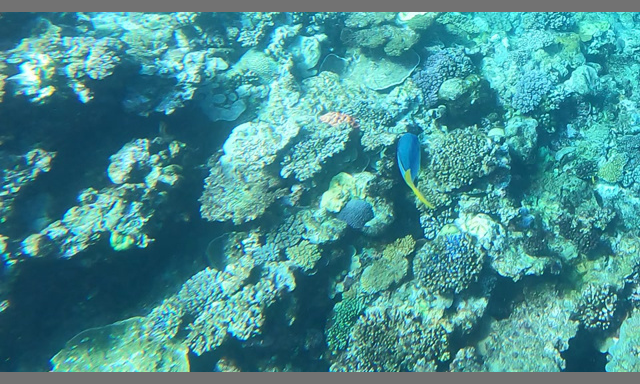

In [190]:
from reef.plot import plot_pil

i = 2
labels_ = np.array(labels[i])[:, 1:] if len(labels[i]) else []
plot_pil(imgs[i], labels_)

In [184]:
np.array(labels[i])[:, 1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed